# Monoaural source separation using NMF with Frobenius norm

In the associated paper, an analysis of the separation of sources using the Frobenius norm, KL divergence and the proposed algorithm is provided. In this, we perform separatiion using only the Frobenius norm, using the scikit learn implementation and the local implementation in tools.py.

In [40]:
import os
from os import listdir
from os.path import join
import sys

import librosa
import librosa.display
from librosa.core import resample
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy.io.wavfile import write
from sklearn.decomposition import NMF


# relative imports as the directory structure is
# blah-blah/source_separation/examples,
# blah-blah/source_separation/nmf,
sys.path.insert(0,"../../source_separation/")
from sourcesep.sourcesep import *
from tools.basic_functions import *


figsize = (10,8)
matplotlib.rcParams.update({'font.size': 22})

In [41]:
path_audio = "orig4.wav"
path_rescaled_components = "orig4_rescaled/"

# The audio signal

The audio is created by mixing 7 different instruments. The time domain signal is displayed below. A few notes regarding the implementation:
* Librosa makes several inherent assumptions regarding the signal. It usually defaults to a 22.5kHz sampling rate and some other default hopsizes and so forth.
* It is therefore prudent to set the sampling rate and all the other parameters for each function being used carefully and manually.
* Librosa is still used regardless of this caveat because it has a rich variety of tools for the purpose of audio signal processing that come very much in handy. 
* The sampling rate for all the audios provided by the author is 44.1 kHz. 
* Further, SciPy scales the audios to make all the samples integer valued. Librosa does not.
* All audio used here is single channel and hence loaded as mono.

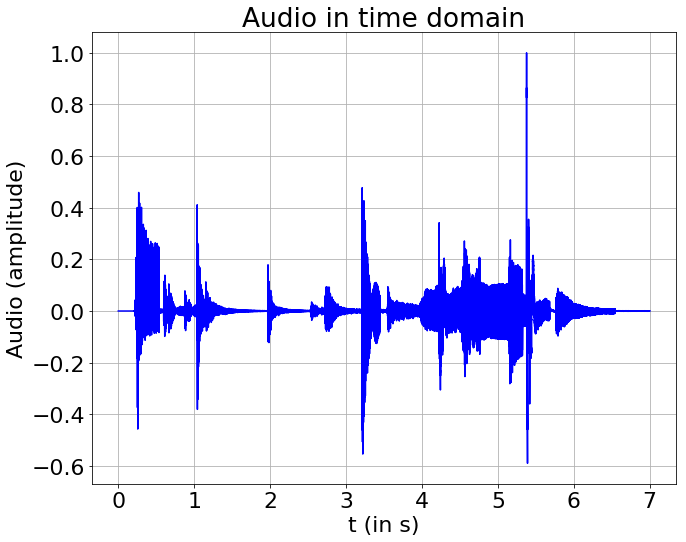

308700


In [42]:
# loading audios
fs_target = 44100
audio, fs = librosa.load(path_audio,sr = fs_target)
# time domain representation
x = np.arange(len(audio))/fs_target
plotfigure(figsize, "t (in s)", "Audio (amplitude)", "Audio in time domain",x,audio,style= "b-" )
print(len(audio))

The parameters are set using the values provided in the paper [1].

In [43]:
# fft details in time units
frame_size = 40e-3
overlap = 0.5
dft_size = frame_size

# fft details in terms of samples
n_fft = int(frame_size*fs_target) # datatype is an advantage for future use
hop_length = int((1-overlap)*frame_size*fs_target)

# DECISION MADE HERE! for window, center, and reflect 
window = scipy.signal.hann(n_fft)

print(n_fft)

1764


# The spectrogram

We obtain a STFT using the specifications provided in [1]. Thus we use a frame size of 40ms and a hop length of 20ms. The sampling rate is 44,100 Hz. A hann window is used for the STFT. It is not clear why the author has chosen to use a Hann window. This remains to be seen. 

A few notes and TODOs regarding the implementation:
* Librosa assumes a number of default values in the case of the STFT extraction and the display. For instance, it uses a default sampling rate of 22.5kHz in the display function leading to incorrect frequency axis range. This has to be set to desired sampling frequency rate.
* An experimentation with the center value in librosa needs to be done.
* SciPy uses zero padding whereas librosa uses reflection padding. It remains to be seen how each of these affects the final output.

(883, 351)
1764 882


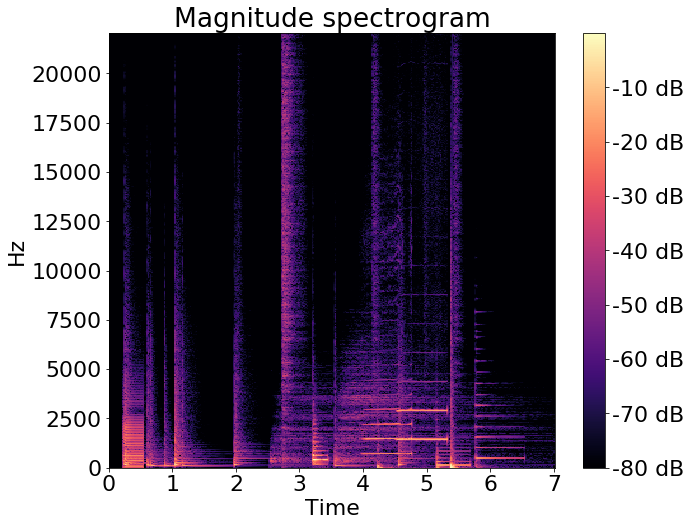

In [44]:
spec = librosa.core.stft(audio, n_fft = n_fft, hop_length = hop_length, window = scipy.signal.hann(n_fft), center= True )
print(np.shape(spec))
print(n_fft, hop_length)
D = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
plt.figure(figsize=figsize)
librosa.display.specshow(D, y_axis='linear', x_axis='time', sr = fs_target, hop_length = n_fft/2)
plt.colorbar(format='%+2.0f dB')
plt.title("Magnitude spectrogram")
plt.show()

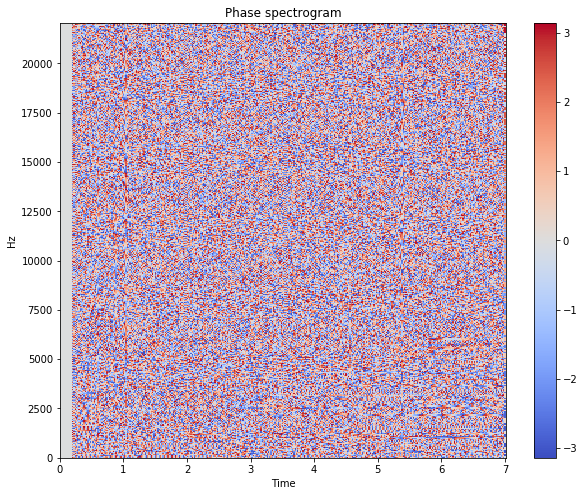

In [6]:
E = np.angle(spec, deg = 0)
plt.figure(figsize=figsize)
librosa.display.specshow(E, y_axis='linear', x_axis='time', sr = fs_target, hop_length = n_fft/2)
plt.title("Phase spectrogram")
plt.colorbar()
plt.show()

# The NMF

We now factorize the magnitude spectrogram using NMF. Ideally, the number of components is determined empirically, by studying the SVD and so forth. However, in this initial implementation, it is assumed that 7 underlying components exist as we already know that the audio was created by mixing 7. This makes the implementation quite easy. The use of more number of components shall be explored in greater depth later.

The Frobenius norm is minimised using the MU rules as the final algorithm depends on MU and comparisions offered in the paper are related to MU.

In [7]:
# modelling componenets by minimizing Least squares norm
model = NMF(n_components=7, init='nndsvd', random_state=0,solver="mu",beta_loss="frobenius",max_iter = 1000)
W = model.fit_transform(np.abs(spec))
H = model.components_
print(model.reconstruction_err_)

226.41500338718959


/home/milind/miniconda3/envs/tf/lib/python3.6/site-packages/sklearn/decomposition/nmf.py:226: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  UserWarning)


## The reconstructed spectrogram

Once the matrices $W$ amd $H$ are obtained, the magnitude spectrogram is reconstructed as 
\begin{equation}
\text{Magnitude Spectrogram} = WH
\end{equation}
This is displayed below. The frequency components near the 3s time frames are clearly missing. This needs to be looked into and requires a clear explanation.

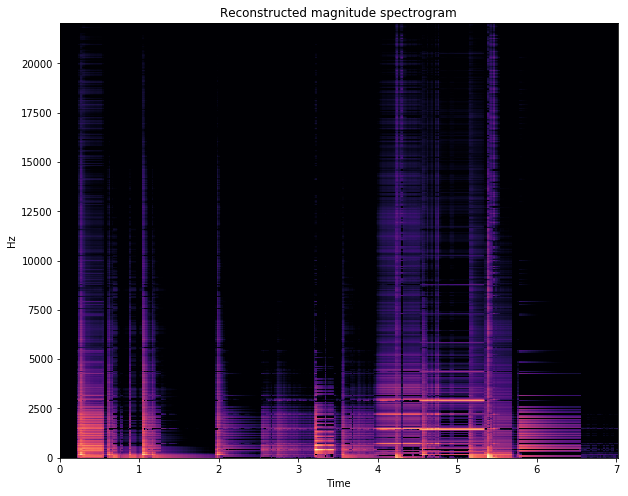

In [8]:
D = librosa.amplitude_to_db((np.matmul(W,H)), ref=np.max)
plt.figure(figsize=figsize)
librosa.display.specshow(D, y_axis='linear', x_axis='time',sr = fs_target, hop_length = n_fft/2)
plt.title("Reconstructed magnitude spectrogram")
plt.show()

# The quality of the reconstruction 

We use following the SNR measure (present in the library sourcesep as SNR(A,B)) to determine the quality of our approximation, where a higher SNR indicates a better performance.

\begin{equation}
\text{SNR} = \frac{\sum_{k,t} [Y]^2_{k,t}}{\sum_{k,t} ([Y]_{k,t} - [\hat{Y}]_{k,t})^2}
\end{equation}

where $Y$ is the original spectrogram and $\hat{Y}$ is the reconstructed spectrogram.

In [9]:
print(SNR(np.abs(spec), np.matmul(W,H)))
print(np.shape(H))

10.02975713442613
(7, 351)


## The $i^{th}$ component

The magnitude spectrogram for the $i^{th}$ component is obtained. The complex spectrogram is obtained by performing an elementwise product with the phase of the original audio. We then perform an ISTFT to obtain the time domain signal. We also plot the time domain signals for the purpose of representation.

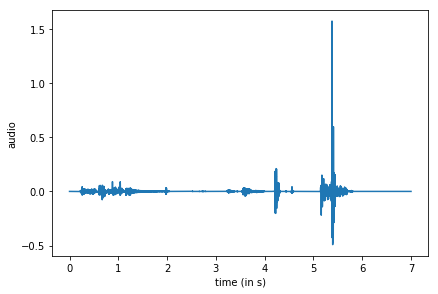

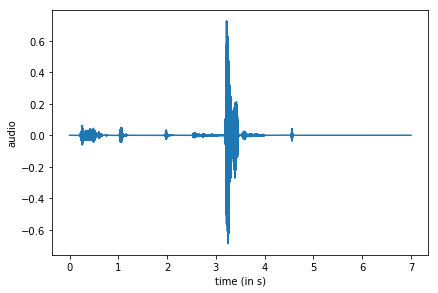

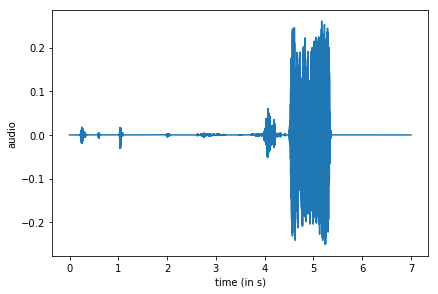

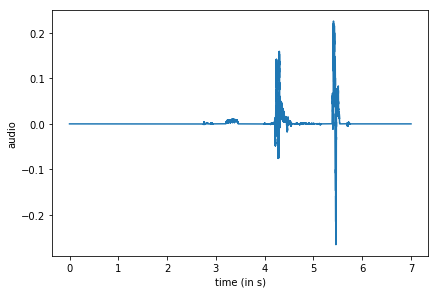

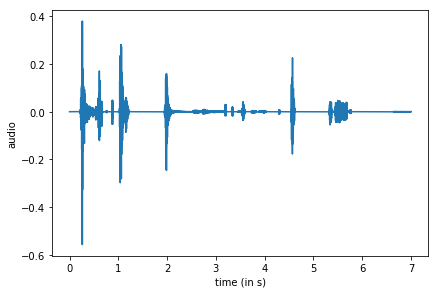

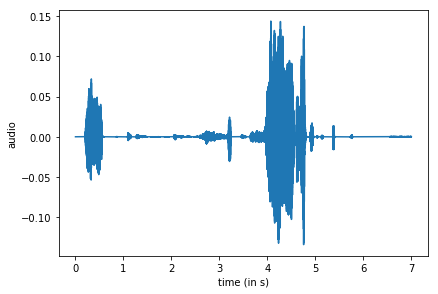

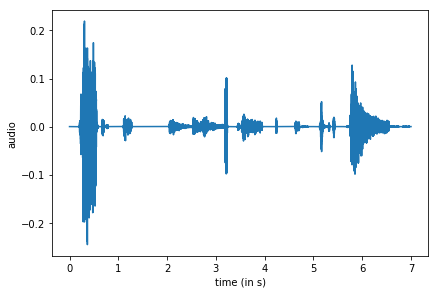

In [10]:
phase = np.angle(spec) # phase of the original signal
# n_fft = 2*np.shape(spec)[0]-1
total = 0
audios = []
for i in range(0,np.shape(W)[1]):
    component= np.outer(W[:,i],(H[i,:]))
    component = component*phase
    audio2 = librosa.core.istft(component, hop_length=n_fft//2)
    audios.append(audio2)
    plt.figure()
    plt.plot(x,audio2)
    plt.tight_layout()
    plt.xlabel("time (in s)")
    plt.ylabel("audio")
    plt.show()
    total = total + audio2 
    write("../../source_separation/Monoaural_source_separation_using_Non-negative_matrix_factorization/orig4_frobenius//component" +str(i) + ".wav", 44100, audio2)
    audio2_rescaled = audio2/ np.max(audio2)
    write("../../source_separation/Monoaural_source_separation_using_Non-negative_matrix_factorization/orig4_frobenius//component" +str(i) + "_rescaled.wav", 44100, audio2_rescaled)

# The reconstructed audio

We superimpose the original time domain signal and the final reconstructed signal.

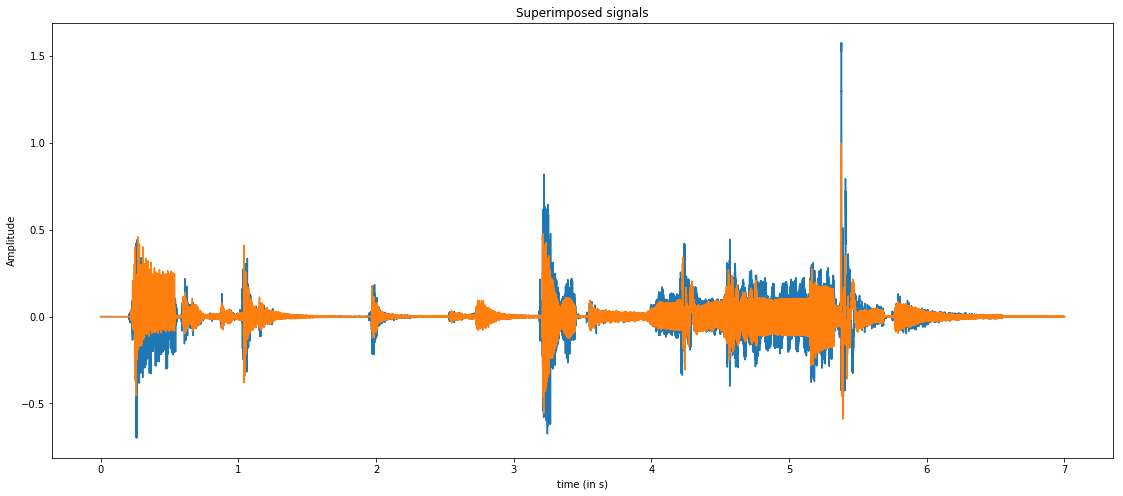

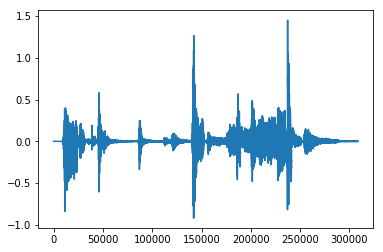

In [11]:
# plotting sum of components and the original signal
plt.figure(figsize = (19,8))
plt.title("Superimposed signals")
plt.xlabel("time (in s)")
plt.ylabel("Amplitude")
plt.plot(x,total)
plt.plot(x,audio)
plt.show()

error = np.array(total) - np.array(audio)
write("../../source_separation/Monoaural_source_separation_using_Non-negative_matrix_factorization/orig4_frobenius/noise.wav", 44100, error)
plt.plot(error)

# Using local implementation

The above code made use of the scikit-learn implementation. Here, we attempt to use the implementation in the file nmf_local.py and check performance. We add a small positive value to the magnitude spectrogram to ensure that we don't run into divisions by zero.

In [12]:
magnitude = np.abs(spec)
nonzero = np.nonzero(magnitude)
minval = (np.min(magnitude[nonzero]))
alpha = minval/1000
print(np.max(magnitude))
print(minval)
print(alpha)
print(type(magnitude[0,0]))
print(np.finfo(np.float32).eps)

127.32795
1.0112213e-06
1.0112213431057172e-09
<class 'numpy.float32'>
1.1920929e-07


In [13]:
corrected = magnitude   + alpha

In [14]:
B,G,_ = lstfind(corrected,7,1000,50)
print(np.shape(G))

cost after 50 iterations: 228.65641110976185
cost after 100 iterations: 221.1224991680865
cost after 150 iterations: 212.34067789281684
cost after 200 iterations: 210.65532009320845
cost after 250 iterations: 209.98160653283895
cost after 300 iterations: 209.82346870993186
cost after 350 iterations: 209.74797857805794
cost after 400 iterations: 209.68388990555485
cost after 450 iterations: 209.65379052524466
cost after 500 iterations: 209.6367671691972
cost after 550 iterations: 209.60656261668007
cost after 600 iterations: 209.59372773092232
cost after 650 iterations: 209.56519210739205
cost after 700 iterations: 209.5401072192347
cost after 750 iterations: 209.53378020754027
cost after 800 iterations: 209.5225818148865
cost after 850 iterations: 209.51978723497942
cost after 900 iterations: 209.50690338386005
cost after 950 iterations: 209.48370544823482
cost after 1000 iterations: 209.45627901375056
(7, 351)


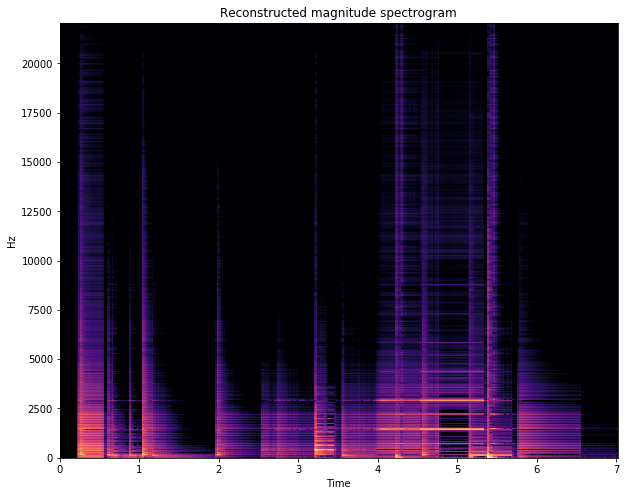

In [15]:
D = librosa.amplitude_to_db((np.dot(B,G)), ref=np.max)
plt.figure(figsize=figsize)
librosa.display.specshow(D, y_axis='linear', x_axis='time', sr = fs_target, hop_length = n_fft/2)
plt.title("Reconstructed magnitude spectrogram")
plt.show()

## Measuring the quality of reconstruction:

Once again, we use the SNR metric designed above to determine the quality of reconstruction. We see that the local implementation produces just as good a SNR as the original signal, if not slightly lower. The reconstruction costs too are very similar. Note that these SNR measurements are only for the full reconstruction and source allocation to components has not been done.

In [16]:
print(SNR(np.abs(spec), np.matmul(B,G)))

11.71963410139721


In [17]:
phase = np.angle(spec)
# n_fft = 2*np.shape(spec)[0]-1
total = 0
audios = []
for i in range(0,np.shape(B)[1]):
    component= np.outer(B[:,i],(G[i,:]))
    component = component*phase
    audio2 = librosa.core.istft(component, hop_length=n_fft//2)
    audios.append(audio2)
    total = total + audio2 
    audio2_rescaled = audio2/ np.max(audio2)


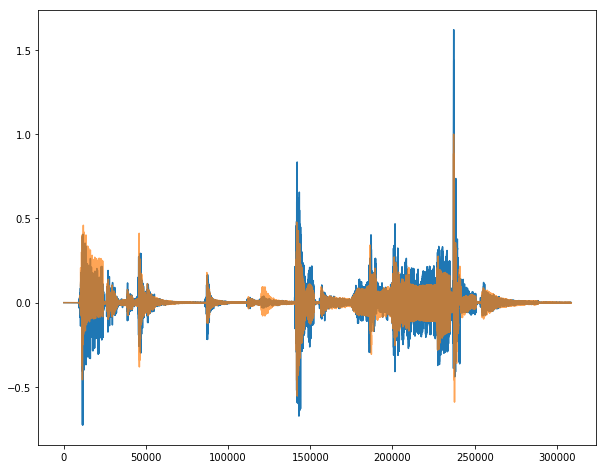

In [18]:
plt.figure(figsize = figsize)

plt.plot(total)
plt.plot(audio, alpha = 0.7)

# Implementing the proposed algorithm


```python
def virtanen007_loss(X, B, G, alpha, beta):
    epsilon1 = np.min(X[np.nonzero(X)])/1000
    recon = np.dot(B,G)
    epsilon2 = np.min(recon[np.nonzero(recon)])/1000
    cr = divcost(X + epsilon1, recon + epsilon2)
    gtj = G[:,1:]
    gt_prevj = G[:,:-1]
    sigmaj = np.sqrt(np.mean(G**2, axis = 1))
    ct = np.sum(np.sum((gtj - gt_prevj)**2, axis = 1)/(sigmaj**2))
    cs = np.sum(np.sum(np.abs(G), axis = 1)/sigmaj)
    cost = cr + ct + cs
    return cost
```

In [19]:
print(virtanen007_loss(np.abs(spec), B, G, 1, 1))

38387.89907488503


In [20]:
divcost(np.abs(spec)+ alpha, np.dot(B,G) + alpha)

21120.544514275407

In [21]:
print(np.finfo(float).eps)
a = 0 
print("a", a)
b = a + np.finfo(np.float32).eps
print(a == b, "b", b)
c = a + np.finfo(np.float32).eps/10
print(a == c, "c", c) 

2.220446049250313e-16
a 0
False b 1.1920928955078125e-07
False c 1.1920928955078126e-08


```python

def virtanen007_find(X, r, alpha, beta, numiter, toprint= None):
        """
    Obtains the factorization for the matrix X by minimising the KL divergence alongwith the use of sparseness and  
    temporal continuity criteria.
    
    Parameters:
    
    X (2d numpy array): the magnitude spectrogram of the audio. Of shape m x n.
    r (int): the number of components to be obtained. 
    alpha (float): coefficient of the temporal continuity term
    beta (float): coefficient of the sparseness term.
    numiter (int): number of iterations of the algorithm to be run.
    toprint (int): number of iterations after which the cost is to be printed. Defaults to None. If None, cost is never
                    printed.
                    
    Returns:
    B (2d numpy array): Matrix of shape m x r whose column vectors form the components for the separated sources.
    G (2d numpy array): Matrix of shape r x n whose ith row forms the time encoding for the ith component of B.
    cost (list): a list of lenght numiter with the cost function calculated at every iteration
    """

    np.random.seed(3)
    eps = np.finfo(np.float32).eps/10
    print("small value being added to prevent nan: ",eps)
    print("minimum value of input magnitude spectrogram: ", np.min(X[np.nonzero(X)]))
    m = np.shape(X)[0]
    n = np.shape(X)[1]
#     B = np.random.random((m,r)) + eps
#     G = np.random.random((r,n)) + eps
    # trying gaussian noise
    B = np.abs(np.random.randn(m,r))# + eps
    G = np.abs(np.random.randn(r,n))#  + eps

    X = X + eps
    cost=[virtanen007_loss(X, B, G, alpha, beta)]
    one = np.ones((m,n))
    if toprint == None:
        toprint = numiter + 1
        
    for i in range(1,numiter+1):
        B = B*(np.dot(X/np.dot(B,G),G.T))/(np.dot(one, G.T))
        
        sigmaj = np.sqrt(np.mean(G**2, axis = 1, keepdims = True))
        
        crplus = np.dot(B.T, one)
        
        crminus =  np.dot(B.T, X/np.dot(B,G))
        
        ctplus = 4*G/(sigmaj**2)
        
        T = np.shape(G)[1]
        
        g0 = G[:,0]
        g0 = g0[:, np.newaxis]
        gn = G[:,-1]
        gn = gn[:, np.newaxis]
        gtminus = np.append(g0, G[:,:-1], axis = 1)
        gtplus = np.append(G[:,1:], gn, axis = 1)
        term1 = (2)*((gtminus + gtplus)/(sigmaj**2))
        diff_square = np.sum((G[:,1:] - G[:,:-1])**2, axis =1, keepdims = True)
        term2 = G*(2/(T*sigmaj**4))*diff_square
        ctminus = term1 + term2
        
        csplus = np.repeat(1/sigmaj, np.shape(G)[1], axis = 1)
        
        colsum = np.sum(G, axis = 1, keepdims= True)
        csminus = G*colsum/((sigmaj**3)*T)
        
        derplus = crplus + alpha*ctplus + beta*csplus
        derminus = crminus + alpha*ctminus + beta*csminus
            
        G = G*(derminus/derplus)
        cost.append(virtanen007_loss(X, B, G , alpha, beta))
        if i%toprint==0:
            print("cost after " +str(i) + " iterations: " + str(cost[-1]))
            
    return (B,G,cost)

def reconmag_r_components(B,G):
    """
    Parameters
    
    B : matrix (m x r) whose column vectors act as the basis vectors for the separated sources
    G : matrix (r x n) whose ij_th element corresponds to the gain of the ith component in the jth time frame
    
    
    Return
    
    components : list of the magnitude spectrograms of the separated components   
    
    """
    m = np.shape(B)[0]
    n = np.shape(G)[1]
    r = np.shape(B)[1]
    if np.shape(G)[0] != r:
        print("B and G can not be multiplied")
        return
    components = []
    for i in np.arange(0,r):
        componenti = np.outer(B[:,i], G[i,:])
        components.append(componenti)
    
    return components
```

In [22]:
B,G,cost = virtanen007_find(np.abs(spec), 300, 1, 0, 3000, 100)

small value being added to prevent nan:  1.1920928955078126e-08
minimum value of input magnitude spectrogram:  1.0112213e-06
cost after 100 iterations: 4718066.14146439
cost after 200 iterations: 4847182.947621935
cost after 300 iterations: 4863689.541351977
cost after 400 iterations: 4875387.435435296
cost after 500 iterations: 4869226.125953875
cost after 600 iterations: 4853647.6116113
cost after 700 iterations: 4845041.947284879
cost after 800 iterations: 4837871.253916888
cost after 900 iterations: 4832264.952304731
cost after 1000 iterations: 4827740.938817342
cost after 1100 iterations: 4822715.2281762175
cost after 1200 iterations: 4818420.843387982
cost after 1300 iterations: 4813402.629596631
cost after 1400 iterations: 4806027.654541484
cost after 1500 iterations: 4800265.490289163
cost after 1600 iterations: 4800413.127456883
cost after 1700 iterations: 4798446.823507242
cost after 1800 iterations: 4793365.714601059
cost after 1900 iterations: 4788383.890156941
cost after 2

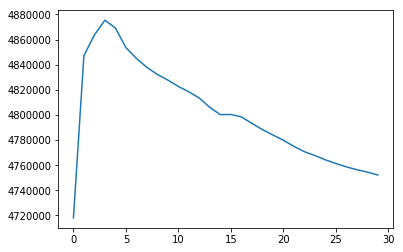

In [23]:
plt.plot(cost[100::100])

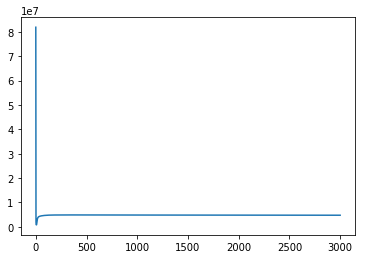

In [24]:
plt.plot(cost)

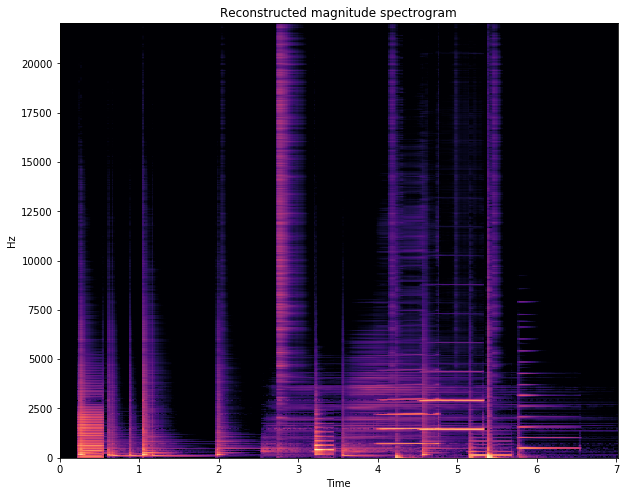

In [25]:
D = librosa.amplitude_to_db((np.dot(B,G)), ref=np.max)
plt.figure(figsize=figsize)
librosa.display.specshow(D, y_axis='linear', x_axis='time',sr = fs_target, hop_length = n_fft/2)
#librosa.display.specshow(np.abs(mag_spec), y_axis='log', x_axis='time')
plt.title("Reconstructed magnitude spectrogram")
plt.show()

In [26]:
print(np.shape(B))
print(np.shape(G))

(883, 300)
(300, 351)


In [27]:
SNR(np.abs(spec), np.dot(B,G))

19.51377799748874

In [28]:
phase = np.angle(spec)
# n_fft = 2*np.shape(spec)[0]-1
total = 0
audios = []
for i in range(0,np.shape(B)[1]):
    component= np.outer(B[:,i],(G[i,:]))
    component = component*phase
    audio2 = librosa.core.istft(component, hop_length=n_fft//2)
    audios.append(audio2)
    total = total + audio2 
    audio2_rescaled = audio2/ np.max(audio2)


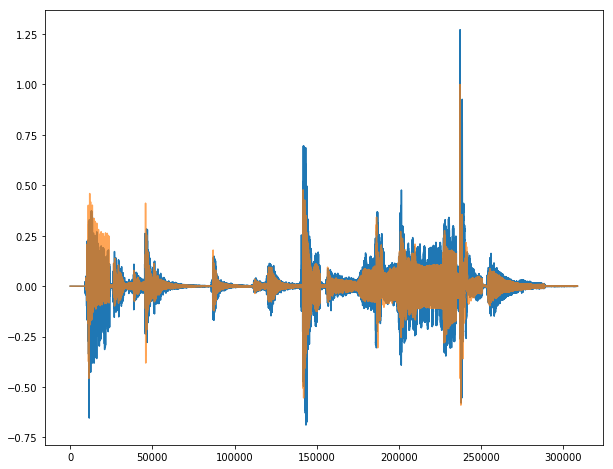

In [29]:
plt.figure(figsize = figsize)
plt.plot(total)
plt.plot(audio, alpha = 0.7)

In [30]:
write("../../source_separation/Monoaural_source_separation_using_Non-negative_matrix_factorization/orig4_virtanen007.wav", 44100, total)

In [31]:
def virtanen007_cluster(sources, components):
    """
    assign each component reconstructed to a source component by finding that source from sources which has 
    the highest SNR with the given component
    
    Parameters: 
        sources : list of magnitude spectra of each source used to create the mixture
        components : list of the magnitude spectra of the components obtained from separation
    
    Returns:
        allocation : list whose kth element is list with zeroth element as source_k and remaining elements as the 
                    components allcoated to it
    
    """
    
    num_sources = len(sources)
    num_components = len(components)
    
    allocation = [[source] for source in sources]
        
    for i in range(num_components):
        component = components[i]
        snrs = [0]*num_sources
        
        for j in range(num_sources):
            source = sources[j]
            snrs[j] = SNR(source, component)
        assgn = np.argmax(snrs)
        allocation[assgn].append(component)
        
    return allocation


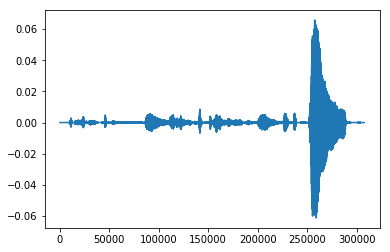

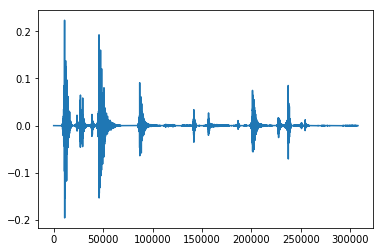

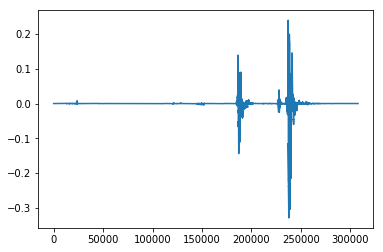

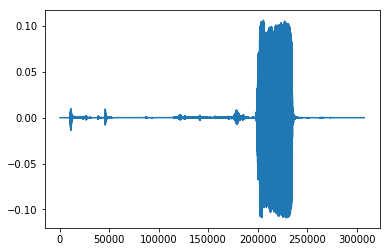

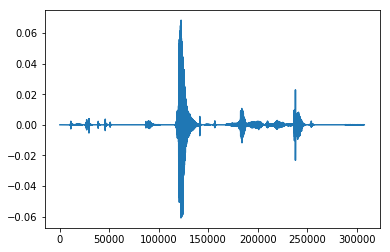

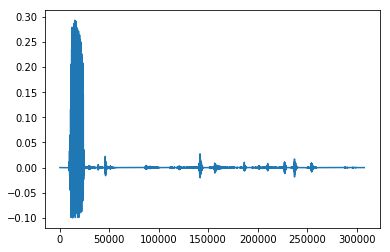

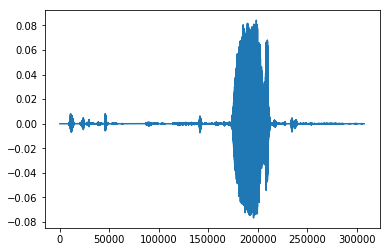

In [32]:
# obtaiining the magnitude components of the sources used ot make the mixture orig4.wav
# TODO: this is highly specific, see if you can generalize this somehow

sources = []
# highly specific to this setup
folder_sources = "orig4_separated/"
path_sources = [os.path.join(folder_sources, i) for i in os.listdir(folder_sources)]
for path_source in path_sources:
    source, fs = librosa.load(path_source, sr = fs_target)
    plt.figure()
    plt.plot(source)
    # adding zeros at the end of the audio to make sure the length of source is 44100*7
    source = np.pad(source, (0,881), "constant", constant_values = (0,0) )
    spec = librosa.core.stft(source, n_fft = n_fft, hop_length = hop_length, window = scipy.signal.hann(n_fft))
    sources.append(spec)
# sources = all complex matrices
magspec_sources = [np.abs(spec) for spec in sources]
phasespec_sources = [np.angle(spec) for spec in sources]

In [33]:
# obtaining components

components = reconmag_r_components(B,G)
num_components = (len(components))
num_sources = (len(magspec_sources))

In [34]:
allocation = virtanen007_cluster_all(magspec_sources, components)

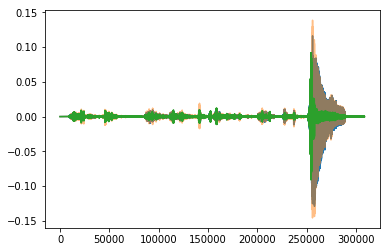

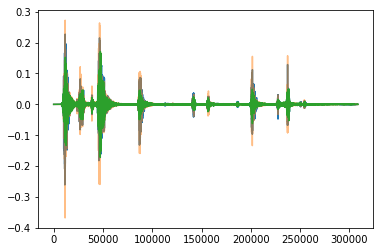

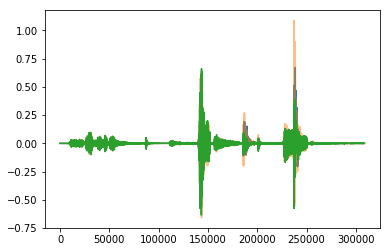

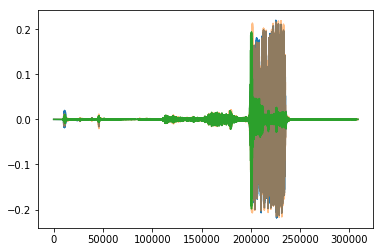

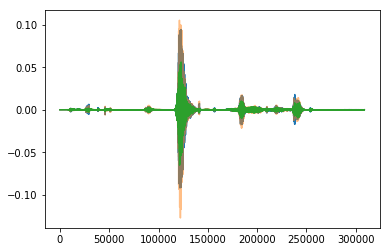

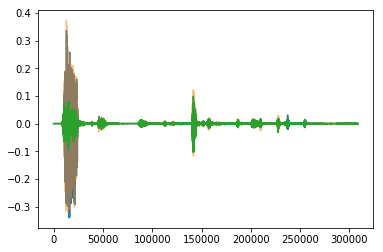

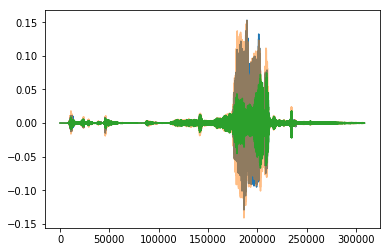

In [35]:
total1 = 0
total2 = 0
for i in range(num_sources):
    source = librosa.core.istft((allocation[i][0])*(phasespec_sources[i]), hop_length=n_fft//2)
    recon = 0
    for j in np.arange(1,np.shape(allocation[i])[0]):
        recon = recon + librosa.core.istft((allocation[i][j]*phase), hop_length=n_fft//2)
    plt.figure()  
    plt.plot(source)
    plt.plot(recon, alpha = 0.5)    
    plt.plot(source - recon)
    total1 = total1 + source
    total2 = total2 + recon

In [36]:
print(np.shape(allocation))

(7,)


In [37]:
for i in range(num_sources):
    print(np.shape(allocation[i]))

(238, 883, 351)
(10, 883, 351)
(11, 883, 351)
(7, 883, 351)
(20, 883, 351)
(7, 883, 351)
(14, 883, 351)


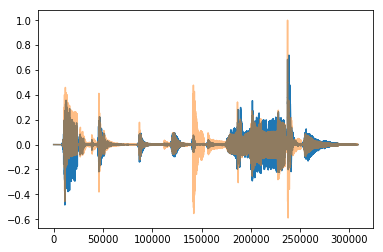

In [38]:
plt.plot(total1)
plt.plot(audio, alpha = 0.5)

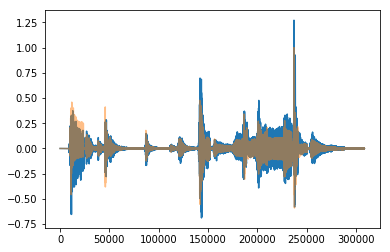

In [39]:
plt.plot(total2)
plt.plot(audio, alpha = 0.5)